### First steps

1. Install alpaca package on the terminal through 

        pip install alpaca-proteomics
        


2. Import the package


In [12]:
from alpaca_proteomics import alpaca

### Data import and formatting

Alpaca works with unprocessed proteomics datasets from MaxQuant. The package takes the file `proteinGroups.txt`, which can be found in the combined folder of MaxQuant output. This dataset is from the exoproteome data published in [Ferrero-Bordera et al. 2024. Microbiology Spectrum](https://doi.org/10.1128/spectrum.02616-23).

In [2]:
file = 'proteinGroups.txt'

# Data importation

df = alpaca.eats(file) #returns a dataframe with the unprocessed MaxQuant output

# Data pre-processing

clean_df, conditions, lfq_method = alpaca.spits(df)
clean_df.sample(5)

Items marked on ['Only identified by site', 'Reverse', 'Potential contaminant'] have been removed from the dataset.
Dataset formated for further analysis and visualisation.


,Accession,Protein,Mol. weight [kDa],Sample,iBAQ,Condition,Replicate
14084,P32727,NusA,41.725,Diamide_03,20.632807,Diamide,Replicate_3
13658,O34394,YjjA,29.836,Diamide_03,17.390958,Diamide,Replicate_3
3028,O34667,LuxS,17.714,Before_Induction_03,17.233975,Before_Induction,Replicate_3
14253,P39846,PpsB,290.160,Diamide_03,9.030308,Diamide,Replicate_3
41,O06748,YitM,21.464,Before_Induction_01,14.916533,Before_Induction,Replicate_1


### Anchor protein quantification

Absolute quantification using Alpaca is optimised for label-free methods, relying on the addition of a set of anchor proteins at a know amount. 

**Table 1.** Format for the file describing the stock solution of anchor proteins.

| Accession  | MW (kDa) | Amount (fmol) |
|------------|---------:|--------------:|
| P02768     |   10.1   |         50    |
| Q9Y6K9     |   65.8   |        100    |
| P05067     |   32.5   |         25    |
| O75475     |   48.2   |         75    |
| Q00653     |   20.9   |         30    |

Got column: Amount (fmoles) - Calculating fmols for you
UPS2 standards vial concentration: 0.5 µg/µl | Resuspended in: 21.2 µl
6.0 µl added to the sample
Coefficients: [[1.08494535]]
Intercept: [12.64700899]
Mean squared error: 1.31
Coefficient of determination: 0.92


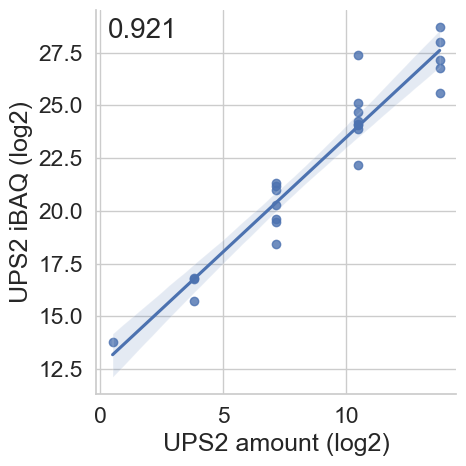

In [4]:
# Import the file containing the information about the quantification standards proteins

standards_file = 'UPS2.xlsx'
st_proteins = alpaca.eats(standards_file)

# If applicable, define which samples/replicates contain standards proteins

spiked_samples = ['Before_induction_01', 'Control_01', 'Diamide_01']

# Quantify the fmol present in the measured samples

quant_df, st_proteins, coef, inter, r2 = alpaca.census(clean_df, st_proteins, 
                                                      filter_col = 'Sample', # Defines which column to filter for the spiked samples
                                                      added_samples = spiked_samples) # Adding which samples contain the standars

`alpaca.census()` adds a column to the processed data with the calculated mol amounts present in the measured samples.

### Experimental details


In [5]:
params = alpaca.eats('params.csv')
params.sample()

,Condition,SampleVolume,ProteinConcentration,AmountMS,CellsPerML,TotalCultureVolume,ProteinSRM,fmolSRM,Enrichment,EnrichmentDirection,StdDilution,StdVolume
0,Before_Induction,2.565198,2.588173,7.116433,0.757594,1.030139,P68871,0.327032,True,Up,2.977484,3.852749


Experimental details (in our example `params.txt`) can be added as txt, csv or xlsx formats. This file can include the columns described in the following table:

**Table 2.** Experimental parameters table. This example covers all possible columns. Nonetheless, not all columns are necessary. For example, Enrichment columns (EnrichmentDirection, StdDilution, StdVolume) are only used if any enrichment step was performed. More information about this is described in the Enrichment section.

| Condition   | SampleVolume | ProteinConcentration | AmountMS | CellsPerML | TotalCultureVolume | ProteinSRM | fmolSRM | Enrichment | EnrichmentDirection | StdDilution | StdVolume |
|-------------|--------------|----------------------|----------|------------|--------------------|------------|---------|------------|---------------------|-------------|-----------|
| Cond1_t0    | 2.31         | 2.99                 | 9.67     | 4.54       | 7.54               | TNAMLN     | 4.44    | False      | Down                | 3.96        | 1.22      |
| Cond2_t1    | 2.50         | 0.20                 | 4.10     | 5.13       | 2.62               | AJFVYC     | 4.85    | True       | Down                | 2.43        | 1.51      |
| Cond3_t2    | 7.38         | 6.56                 | 2.77     | 3.66       | 3.80               | BYEKSC     | 9.71    | True       | Down                | 5.71        | 8.53      |

### Proteome fraction enrichment (Optional)

In case the study focuses in a fraction of the proteome (e.g., membrane proteome or exoproteome), it is likely that during the sample preparation and enrichment step was performed. This module allows to translate the enrichment step to the data based on how the samples were prepared. 

`Enrichment factors` are calculated based on the fmol quantified in the enriched sample to the raw or non-enriched sample:

$$
ER = \frac{fmol_{enriched}}{fmol_{non-enriched}}
$$

For that purpose, there are 2 strategies that are currently covered under our pipeline:

**1. The quantification of specific proteins of the analysed fraction on both before and after the enrichment step using Targeted MS (SRM).** 

This strategy was described on [Antelo-Varela et al. 2019](https://pubmed.ncbi.nlm.nih.gov/31424929/) and relies on using external protocols (e.g., Skyline) to quantify the enrichment step. Enrichment factors can be added to the parameters table under the column `Enrichment_Factor`. Additionally, the SRM quantified amount for a given protein can be added on the columns `ProteinSRM` (Accession of the quantified protein) and `fmolSRM` (Quantified fmol in the analysed proteome fraction).

**2. The addition of whole proteins at known concentration before performing the enrichment step.**

This approach was described on [Ferrero-Bordera et al. 2024](https://doi.org/10.1128/spectrum.02616-23) and requires of a protein mixture at known concentration added before the enrichment step. Used standards have to be formatted as specified in the table below:

**Table 3.** Enrichment standards

| Accession | MW (kDa) | StdConcentration (µg/µl) |
|-----------|---------:|-------------------------:|
| P02768    |     10.1 |                     2.5  |
| Q9Y6K9    |     65.8 |                     0.8  |
| P05067    |     32.5 |                     1.2  |
| O75475    |     48.2 |                     3.0  |
| Q00653    |     20.9 |                     2.0  |


In [6]:
enrichment = alpaca.eats('enrichment_std.xlsx').rename(columns={'Mix concentration (µg/µl)':'StdConcentration'})
enrichment.sample(3)

,Protein,Accession,Chain length,MW (kDa),StdConcentration
0,a-Lactalbumin,P00711,122 aa,14.3,174.073061
6,Carbonic Anhydrase,P00921,261 aa,29.0,3.605799
1,Glyceraldehyde-3-phosphate dehydrogenase,P46406,334 aa,37.0,460.050233


In [7]:
enrichment_std, sample_prep_updated = alpaca.gathers(clean_df, enrichment, params)
clean_df.sample()

Enrichment factor on condition: 0 = Condition           Before_Induction
EnrichmentFactor           26.819017
Name: 0, dtype: object
Enrichment factor on condition: 1 = Condition             Control
EnrichmentFactor    30.048362
Name: 1, dtype: object


,Accession,Protein,Mol. weight [kDa],Sample,iBAQ,Condition,Replicate,fmol
12905,P39797,XepA,30.345,Diamide_02,20.102006,Diamide,Replicate_2,117.076806


### Data integration

This module connects the protein amounts quantified in the sample and the sample preparation. Thus, allowing to calculate protein amounts to the original state (e.g. bacterial culture, raw culture supernatant). This step brings deeper insights to the user based on the known experimental parameters, yielding high valuable data (e.g., molecules per cell, fmol / µmol of protein extract)

In [8]:
results = alpaca.wool(quant_df, sample_prep_updated)

results.sample(3)

,Accession,Protein,Mol. weight [kDa],Sample,iBAQ,Condition,Replicate,fmol,Molecules,fmolSample,MoleculesPerCell
11414,P33166,Tuf,43.593,Diamide_01,25.802451,Diamide,Replicate_1,6941.783615,2.161041e+13,35879.808549,1.144550e+12
2062,P33166,Tuf,43.593,Before_Induction_02,23.831324,Before_Induction,Replicate_2,0.275156,1.546121e+08,0.256703,1.981124e+08
4349,O34595,ThiI,45.465,Before_Induction_04,15.996937,Before_Induction,Replicate_4,0.001844,1.036351e+06,0.001721,1.327929e+06
